### Envsetup

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

In [ ]:
!pip install gpytorch

### Imports

In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
import torch
import gpytorch
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

### Visualization

In [3]:
def readflo(filename):
    with open(filename, "rb") as f:
        if np.fromfile(f, np.float32, count=1) != 202021.25:
            raise ValueError(f"Invalid .flo file: {filename}")
        w = np.fromfile(f, np.int32, count=1)[0]
        h = np.fromfile(f, np.int32, count=1)[0]
        d = np.fromfile(f, np.float32, count=(2 * w * h))
        return np.resize(d, (h, w, 2))

def writeflo(filename, flows):
    with open(filename, "wb") as f:
        np.array(202021.25, dtype=np.float32).tofile(f)
        np.array(flows.shape[1], dtype=np.int32).tofile(f)
        np.array(flows.shape[0], dtype=np.int32).tofile(f)
        flows.astype(np.float32).tofile(f)

In [4]:
def visimg(img1, img2, figsize=(10, 4)):
    fig, axs = plt.subplots(ncols=2, figsize=figsize)
    axs[0].imshow(img1, cmap="grey")
    axs[1].imshow(img2, cmap="grey")
    axs[0].axis("off")
    axs[1].axis("off")
    plt.tight_layout()
    plt.show()

In [5]:
def visflo(u, v, c, sr, scale, agg=max, log=True, figsize=(10, 5), title=""):
    fig = plt.figure(figsize=figsize)
    ax1 = fig.add_axes([0.05, 0.5, 0.4, 0.4])
    ax2 = fig.add_axes([0.55, 0.5, 0.4, 0.4])
    ax3 = fig.add_axes([0.00, 0.0, 0.3, 0.4])
    ax4 = fig.add_axes([0.35, 0.0, 0.3, 0.4])
    ax5 = fig.add_axes([0.70, 0.0, 0.3, 0.4])

    mag = np.sqrt(u ** 2 + v ** 2)
    im1 = ax3.imshow(mag, cmap="viridis")
    im2 = ax4.imshow(u,   cmap="coolwarm")
    im3 = ax5.imshow(v,   cmap="coolwarm")
    
    plt.colorbar(im1, ax=ax3, shrink=0.8)
    plt.colorbar(im2, ax=ax4, shrink=0.8)
    plt.colorbar(im3, ax=ax5, shrink=0.8)
    
    yy, xx = np.mgrid[0:u.shape[0]:sr[0], 0:u.shape[1]:sr[1]]
    uu, vv = u[::sr[0], ::sr[1]], v[::sr[0], ::sr[1]]
    ax1.quiver(xx, yy, uu, -vv, scale=scale)
    ax1.invert_yaxis()

    ax1.set(title="Vector Field", xticks=[], yticks=[])
    ax2.set(title="Covariance",   xticks=[], yticks=[])
    ax3.set(title="Magnitude",    xticks=[], yticks=[])
    ax4.set(title="U Component",  xticks=[], yticks=[])
    ax5.set(title="V Component",  xticks=[], yticks=[])

    viscov(c, (1, 1), agg, log, ax2)
    fig.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

In [6]:
def viscov(cov, sr, agg=max, log=True, axs=None):
    if show := (axs is None):
        fig, axs = plt.subplots(figsize=(5, 4))
    
    yy, xx = np.mgrid[0:cov.shape[0]:sr[0], 0:cov.shape[1]:sr[1]]
    eig = np.zeros_like(xx, dtype=np.float32)
    cc = cov[::sr[0], ::sr[1]]
    for i in range(xx.shape[0]):
        for j in range(xx.shape[1]):
            eig[i, j] = agg(np.linalg.eigvals(cc[i, j]))
    
    eig = np.log(eig) if log else eig
    cm = axs.pcolormesh(xx, yy, eig, cmap="Greys_r")
    plt.colorbar(cm, ax=axs)
    axs.invert_yaxis()
    
    if show:
        axs.axis("off")
        plt.show()

### Maximum Likelihood

In [7]:
def gaussian_mask(window=5, sigma=None, normalize=True):
    if not sigma:
        sigma = window / 3
    center = (window - 1) / 2
    x = np.arange(window) - center
    y = np.arange(window) - center
    xx, yy = np.meshgrid(x, y)
    mask = np.exp(-(xx ** 2 + yy ** 2) / (2 * sigma ** 2))
    return mask / mask.sum() if normalize else mask

In [8]:
def maximum_likelihood(img1, img2, window=9, sigma=1, rhos=[]):
    w = window // 2
    pad1 = cv.copyMakeBorder(img1.astype(np.float32), w, w, w, w, cv.BORDER_REFLECT)
    pad2 = cv.copyMakeBorder(img2.astype(np.float32), w, w, w, w, cv.BORDER_REFLECT)
    Ix = cv.Sobel(pad1, cv.CV_32F, 1, 0, ksize=3)
    Iy = cv.Sobel(pad2, cv.CV_32F, 0, 1, ksize=3)
    It = pad2 - pad1

    u = np.zeros(img1.shape, dtype=np.float32)
    v = np.zeros(img1.shape, dtype=np.float32)
    c = np.zeros(img1.shape + (2, 2), dtype=np.float32)
    mask = gaussian_mask(window, normalize=False)
    noise = ((sigma / mask) ** 2).flatten()
    noise = np.diag(noise) if len(rhos) else noise

    for i in range(img1.shape[0]):
        for j in range(img1.shape[1]):
            m, n = i + w, j + w
            ix = Ix[m-w:m+w+1, n-w:n+w+1].flatten()
            iy = Iy[m-w:m+w+1, n-w:n+w+1].flatten()
            it = It[m-w:m+w+1, n-w:n+w+1].flatten()
            nabla = np.vstack([ix, iy])

            if len(rhos):
                cornoise = correlate(noise, rhos, (m, n), window)
                nabnoise = nabla @ np.linalg.inv(cornoise)
                ercov = np.linalg.inv(nabnoise @ nabla.T)
                flows = -ercov @ nabnoise @ it
            else:
                ercov = np.linalg.inv((nabla / noise) @ nabla.T)
                flows = -ercov @ (nabla / noise) @ it

            u[i, j] = flows[0]
            v[i, j] = flows[1]
            c[i, j] = ercov
    return u, v, c

### Multiresolution Algorithm

In [9]:
def gaussian_pyramid(img, levels):
    pyramid = [img.astype(np.float32)]
    for _ in range(levels - 1):
        pyramid.append(cv.pyrDown(pyramid[-1]))
    return pyramid[::-1]

In [10]:
def measurement_update(img1, img2, uu, vv, cc, window, sigma):
    w = window // 2
    pad1 = cv.copyMakeBorder(img1.astype(np.float32), w, w, w, w, cv.BORDER_REFLECT)
    pad2 = cv.copyMakeBorder(img2.astype(np.float32), w, w, w, w, cv.BORDER_REFLECT)
    Ix = cv.Sobel(pad1, cv.CV_32F, 1, 0, ksize=3)
    Iy = cv.Sobel(pad1, cv.CV_32F, 0, 1, ksize=3)
    It = pad2 - pad1
    
    u  = np.zeros(img1.shape, dtype=np.float32)
    v  = np.zeros(img1.shape, dtype=np.float32)
    c  = np.zeros(img1.shape + (2, 2), dtype=np.float32)
    mask = gaussian_mask(window, normalize=False)
    noise = ((sigma / mask) ** 2).flatten()

    for i in range(img1.shape[0]):
        for j in range(img1.shape[1]):
            m, n = i + w, j + w
            ix = Ix[m-w:m+w+1, n-w:n+w+1].flatten()
            iy = Iy[m-w:m+w+1, n-w:n+w+1].flatten()
            it = It[m-w:m+w+1, n-w:n+w+1].flatten()
            
            nabla = np.vstack([ix, iy])
            fpred = np.array([uu[i, j], vv[i, j]])
            innovation = it + nabla.T @ fpred
            
            ercov = np.linalg.inv(cc[i, j])
            ercov = np.linalg.inv((nabla / noise) @ nabla.T + ercov)
            fpost = fpred - ercov @ (nabla / noise) @ innovation
            
            u[i, j] = fpost[0]
            v[i, j] = fpost[1]
            c[i, j] = ercov
    return u, v, c

In [11]:
def multiresolution_flows(img1, img2, window, sigmaQ, sigmaR, k=3, r=2):
    lvls = int(np.log2(img1.shape).min() - k)
    pyr1 = gaussian_pyramid(img1, lvls)
    pyr2 = gaussian_pyramid(img2, lvls)
    u1, v1, c1 = maximum_likelihood(pyr1[0], pyr2[0], window[0], sigmaR[0])
    pyramid = [(u1, v1, c1)]
    A = r * np.eye(2)

    for i in range(1, len(pyr1)):
        h, w = pyr1[i].shape
        u2 = cv.pyrUp(u1, dstsize=(w, h)) * r
        v2 = cv.pyrUp(v1, dstsize=(w, h)) * r
        
        c2 = np.zeros((h, w) + (2, 2))
        for m in range(2):
            for n in range(2):
                c2[..., m, n] = cv.pyrUp(c1[..., m, n], dstsize=(w, h)) * (r ** 2)
        c2 += (sigmaQ[i] * np.eye(2))[None, None, ...]

        
        u1, v1, c1 = measurement_update(
            pyr1[i], pyr2[i], u2, v2, c2, window[i], sigmaR[i]
        )
        pyramid.append((u1, v1, c1))
    return pyramid

### Homoscedastic GPR

In [12]:
class GPROFE(gpytorch.models.ExactGP):
    def __init__(self, X, Y, likelihood):
        super(GPROFE, self).__init__(X, Y, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ConstantMean(), num_tasks=2
        )
        self.covar_module = gpytorch.kernels.MultitaskKernel(
            gpytorch.kernels.RBFKernel(), num_tasks=2, rank=1
        )
    def forward(self, X):
        mean = self.mean_module(X)
        covar = self.covar_module(X)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean, covar)

In [13]:
def train(model, likelihood, X, Y, lr=0.1, epochs=100):
    model.train()
    likelihood.train()
    opti = torch.optim.Adam(model.parameters(), lr=lr)
    emll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    for n in range(epochs):
        opti.zero_grad()
        output = model(X)
        loss = -emll(output, Y)
        loss.backward()
        opti.step()
        if not (n + 1) % 10:
            print(f"Iteration {n + 1}: Loss {loss.item()}")

In [14]:
def pred(model, likelihood, X):
    model.eval()
    likelihood.eval()
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        pred = model(X)
    return pred.mean, pred.variance, pred.covariance_matrix

### Empirical Images

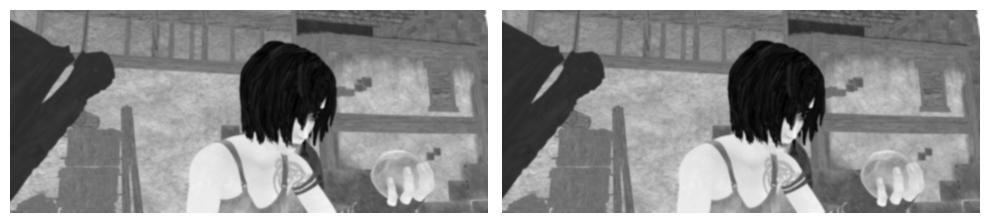

In [15]:
img1 = cv.imread("mpisintel/training/albedo/alley_1/frame_0001.png")
img2 = cv.imread("mpisintel/training/albedo/alley_1/frame_0002.png")
img1 = cv.cvtColor(img1, cv.COLOR_BGR2GRAY)
img2 = cv.cvtColor(img2, cv.COLOR_BGR2GRAY)
img1 = cv.GaussianBlur(img1, (9, 9), -1)
img2 = cv.GaussianBlur(img2, (9, 9), -1)
visimg(img1, img2)

/tmp/ipykernel_184944/3142062085.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


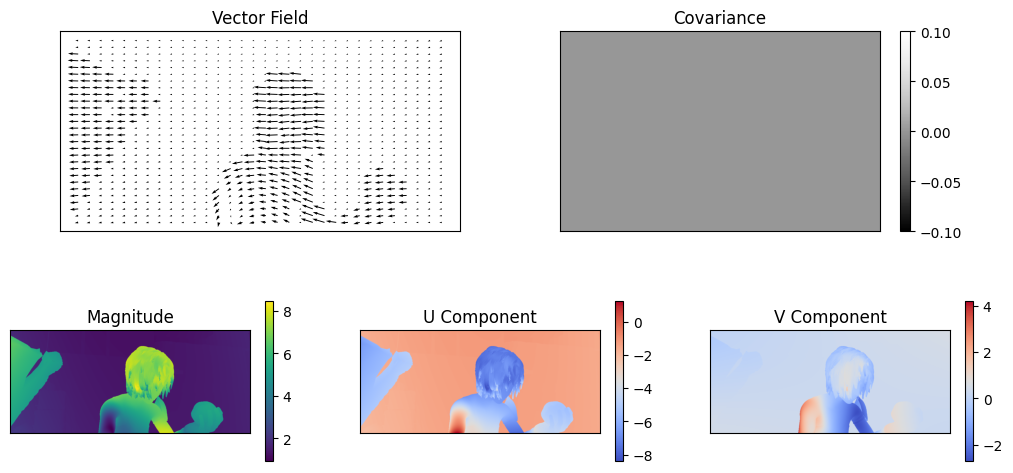

In [16]:
f = readflo("mpisintel/training/flow/alley_1/frame_0001.flo")
visflo(f[..., 0], f[..., 1], np.zeros(img1.shape + (2, 2)),
       sr=(16, 32), scale=250, figsize=(10, 5), log=False)

### Training (Maximum Likelihood)

In [17]:
u, v, c = maximum_likelihood(img1, img2, 25, 1)
yy, xx = np.mgrid[0:img1.shape[0]:16, 0:img1.shape[1]:32]
uu, vv = u[::16, ::32], v[::16, ::32]
X = torch.tensor(np.dstack((xx, yy)).reshape(-1, 2), dtype=torch.float32)
Y = torch.tensor(np.dstack((uu, vv)).reshape(-1, 2), dtype=torch.float32)
likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=2, rank=1)
model = GPROFE((X - X.mean()) / X.std(), Y, likelihood)

In [18]:
train(model, likelihood, (X - X.mean()) / X.std(), Y, epochs=200)

Iteration 10: Loss 0.46788260340690613
Iteration 20: Loss 0.05280917137861252
Iteration 30: Loss -0.2567484676837921
Iteration 40: Loss -0.36874526739120483
Iteration 50: Loss -0.3868228495121002
Iteration 60: Loss -0.39947429299354553
Iteration 70: Loss -0.40694740414619446
Iteration 80: Loss -0.41072162985801697
Iteration 90: Loss -0.4229882061481476
Iteration 100: Loss -0.4965182840824127
Iteration 110: Loss -0.523773193359375
Iteration 120: Loss -0.5556891560554504
Iteration 130: Loss -0.5693811774253845
Iteration 140: Loss -0.5767221450805664
Iteration 150: Loss -0.5776280164718628
Iteration 160: Loss -0.5783782601356506
Iteration 170: Loss -0.5787604451179504
Iteration 180: Loss -0.5790091753005981
Iteration 190: Loss -0.579035758972168
Iteration 200: Loss -0.579045832157135


/home/andy/tensorflow/lib64/python3.12/site-packages/gpytorch/models/exact_gp.py:296: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(
/tmp/ipykernel_184944/3142062085.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


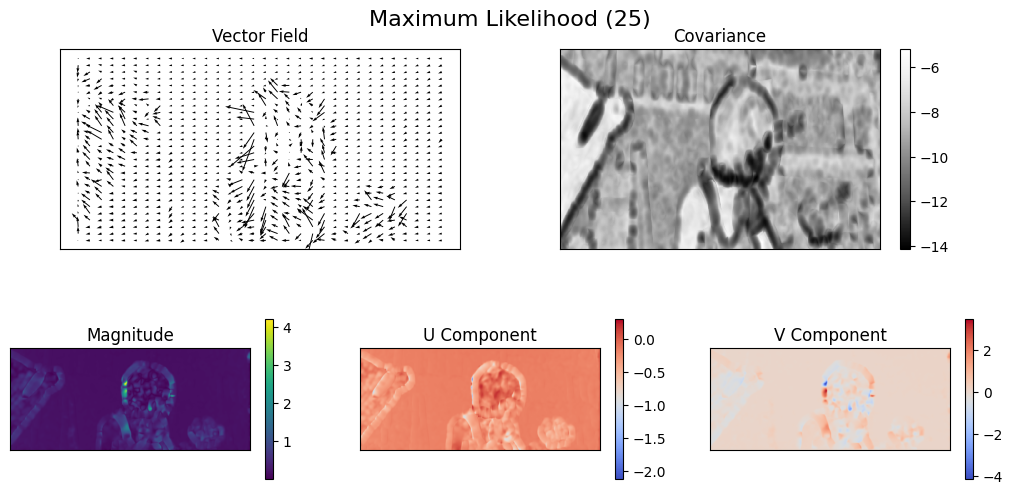

/tmp/ipykernel_184944/3142062085.py:9: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  mag = np.sqrt(u ** 2 + v ** 2)


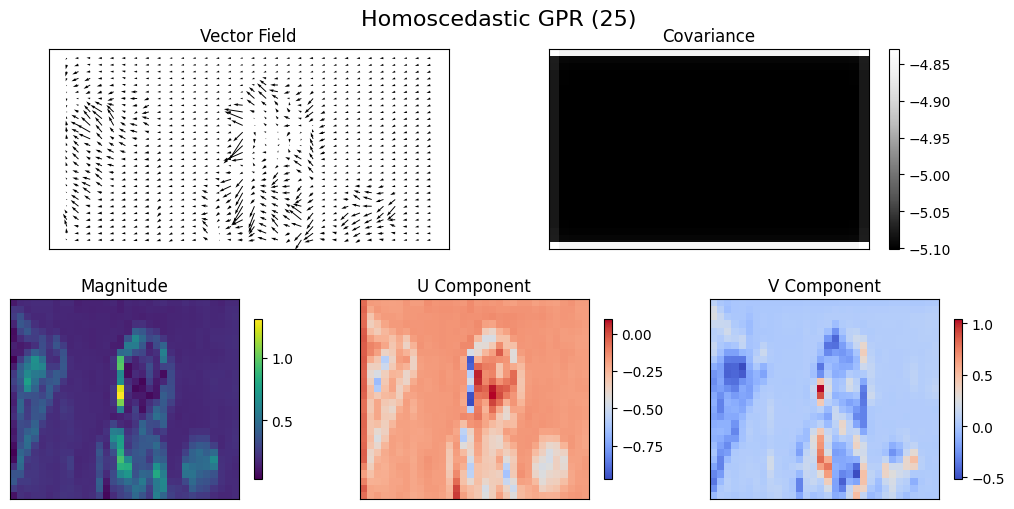

In [19]:
mean, var, covar = pred(model, likelihood, (X - X.mean()) / X.std())
uu = mean.reshape(xx.shape + (2,))[..., 0]
vv = mean.reshape(xx.shape + (2,))[..., 1]
cc = [covar.detach()[i:i+2, i:i+2] for i in range(0, covar.shape[0], 2)]
cc = np.array(cc).reshape(xx.shape + (2, 2))
visflo(u, v, c, (16, 32), 20, title="Maximum Likelihood (25)")
visflo(uu, vv, cc, (1, 1), 20, title="Homoscedastic GPR (25)")

### Training (Multiresolution)

In [20]:
u, v, c = multiresolution_flows(
    img1, img2,
    [  9, 13, 17, 21,  25],
    [256, 64, 16,  4,   1],
    [  1,  4, 16, 64, 256]
)[-1]
yy, xx = np.mgrid[0:img1.shape[0]:16, 0:img1.shape[1]:32]
uu, vv = u[::16, ::32], v[::16, ::32]
X = torch.tensor(np.dstack((xx, yy)).reshape(-1, 2), dtype=torch.float32)
Y = torch.tensor(np.dstack((uu, vv)).reshape(-1, 2), dtype=torch.float32)
likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=2, rank=1)
model = GPROFE((X - X.mean()) / X.std(), Y, likelihood)

In [21]:
train(model, likelihood, (X - X.mean()) / X.std(), Y, epochs=200)

Iteration 10: Loss 0.44285154342651367
Iteration 20: Loss 0.01790550723671913
Iteration 30: Loss -0.3307080864906311
Iteration 40: Loss -0.4848780035972595
Iteration 50: Loss -0.5147514343261719
Iteration 60: Loss -0.5413195490837097
Iteration 70: Loss -0.555705726146698
Iteration 80: Loss -0.57990562915802
Iteration 90: Loss -0.6381697058677673
Iteration 100: Loss -0.6639488935470581
Iteration 110: Loss -0.6877238154411316
Iteration 120: Loss -0.7013368606567383
Iteration 130: Loss -0.7045567631721497
Iteration 140: Loss -0.7081664204597473
Iteration 150: Loss -0.7084909081459045
Iteration 160: Loss -0.7071065902709961
Iteration 170: Loss -0.7083950042724609
Iteration 180: Loss -0.709010660648346
Iteration 190: Loss -0.7091450095176697
Iteration 200: Loss -0.7091530561447144


/tmp/ipykernel_184944/3142062085.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


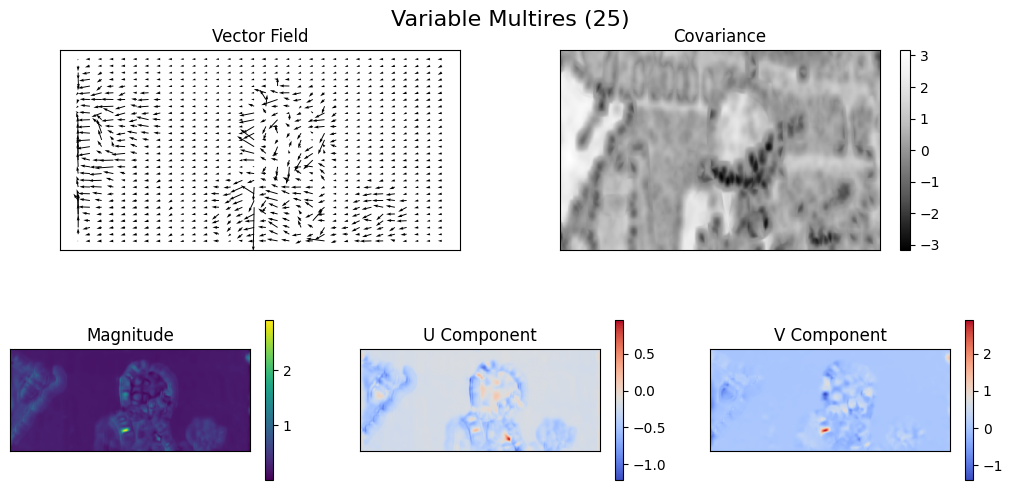

/tmp/ipykernel_184944/3142062085.py:9: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  mag = np.sqrt(u ** 2 + v ** 2)


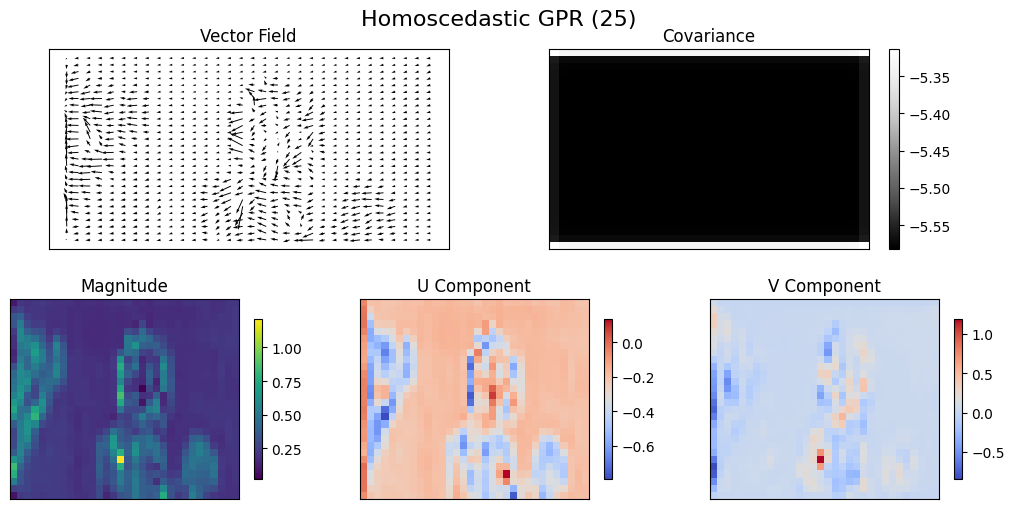

In [22]:
mean, var, covar = pred(model, likelihood, (X - X.mean()) / X.std())
uu = mean.reshape(xx.shape + (2,))[..., 0]
vv = mean.reshape(xx.shape + (2,))[..., 1]
cc = [covar.detach()[i:i+2, i:i+2] for i in range(0, covar.shape[0], 2)]
cc = np.array(cc).reshape(xx.shape + (2, 2))
visflo(u, v, c, (16, 32), 20, title="Variable Multires (25)")
visflo(uu, vv, cc, (1, 1), 20, title="Homoscedastic GPR (25)")